**RANDOM FOREST - ROC-AUC - hERG - QSAR** 

Preparation Steps to get the data into a form acceptable that can be understood by machine learning model. Depending on the initial data set, there may be extra work involved such as : one-hot encode categorical variables, converte to arrays, removing outliers, imputing missing values, converting temporal varaibles into cyclical repressentations. 

**Step 1 : Import modules** 

In [4]:
import pandas as pd                                                   # to load pandas used for data manipulation
import numpy as np                                                    # to load numpy 
from sklearn.ensemble import RandomForestClassifier                   # to build a random forest classifier 

from sklearn.metrics import matthews_corrcoef                         # to load mathew correlation coefficient score 

from sklearn.metrics import roc_curve                                 # to draw roc curve
import matplotlib.pyplot as plt                                       # ...
from sklearn.metrics import roc_auc_score                             # to determine ROC-AUC score

from sklearn.model_selection import KFold                             # to crate folds and perform Cross-Validation
from joblib import dump, load                                         # to save binary object as the models
                    

**Step 2 : Import the data** 

In [5]:
df = pd.read_csv('Dataframe with picks.csv') # to download the data from the file into a dataframe called df
df.head()                                       # to view the top 5 rows 

,Unnamed: 0,SMILES_new,ExactMolWt,qed,FpDensityMorgan2,TPSA,NumHAcceptors,NumHDonors,MolLogP,FractionCSP3,...,Outcome,pIC50,InChIKey,desalted\demetalled,mixture,complex,changes,Clusters,fingerprint,ID
0,2,Cc1cc(C)n(-c2cc(NC(=O)CCN(C)C)nc(-c3ccc(C)o3)n...,368.196074,0.719563,1.962963,89.08,7.0,1.0,2.73776,0.368421,...,1,6.187087,AACWUFIIMOHGSO-UHFFFAOYSA-N,False,False,False,NaN,2,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,PICKS
1,4,Cc1ccc(NC(=O)C(COC(C)C)Oc2ncnc3c2cnn3-c2ncccc2...,467.147265,0.418807,2.000000,116.94,9.0,1.0,3.37842,0.272727,...,0,NaN,AAGISEXHOPCAHZ-UHFFFAOYSA-N,False,False,False,NaN,4,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,PICKS
2,5,Cc1ncoc1-c1nnc(SCCCN2CCC3(CC3c3ccccc3)C2)n1C,409.193631,0.431725,2.103448,59.98,7.0,0.0,4.14032,0.500000,...,1,5.420000,AAPXNHMQKBDDJN-UHFFFAOYNA-N,False,False,False,NaN,5,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,PICKS
3,6,CN(C)Cc1ccc(C(F)(F)F)cc1Oc1ccc(Cl)c(Cl)c1,363.040454,0.673225,1.695652,12.47,2.0,0.0,5.86610,0.250000,...,1,5.950782,AAQZZAVVFRIEOD-UHFFFAOYSA-N,False,False,False,NaN,6,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,PICKS
4,10,O=C(Cc1ccc(-n2cnnn2)cc1)N1CCN(CCc2ccc3c(c2)COC...,418.211724,0.605615,1.709677,76.38,7.0,0.0,1.62190,0.391304,...,1,5.602060,AAYRYIFNKRSGOF-UHFFFAOYSA-N,False,False,False,NaN,7,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,PICKS


**Step 3 : Build a Random Forest model** 

A 10 Fold Cross-Validation is performed to obtain 10 models. 

In [8]:

dict_ytrain_pred = {}         # to store results into dictionaries or lists
dict_yeval_pred = {}

tuned_y_pred = [] # final results

# 1) To define the descriptors and the outcome.
X = df[['ExactMolWt','qed','FpDensityMorgan2','TPSA','NumHAcceptors','NumHDonors','MolLogP','FractionCSP3','NumRotatableBonds','HeavyAtomCount', 'NumAliphaticCarbocycles', 'NumAromaticCarbocycles', 'NumAliphaticHeterocycles','NumAromaticHeterocycles','NumAromaticRings']]
Y = df['Outcome']



# 2) To create 10 folds.
kf = KFold(n_splits=10)                                     
KFold(n_splits=10, random_state=None, shuffle=False)



# 3) To loop over each fold corresponding to a model.
for fold, (train_index, eval_index) in enumerate(kf.split(X,Y)):            
    print("fold n°{}".format(fold))  



    # 3.1) To split the dataset into training and evaluation set.    
    X_train, X_eval = X.take(list(train_index),axis=0), X.take(list(eval_index),axis=0)   
    y_train, y_eval = Y.take(list(train_index),axis=0), Y.take(list(eval_index),axis=0)



    # 3.2) To build a forest of trees from the training set(X,y).
    rf = RandomForestClassifier(n_estimators=600, bootstrap=True, max_depth=40, max_features=4, min_samples_leaf=2, min_samples_split=10,ccp_alpha=0.001419, random_state=50, n_jobs=-1) 
    trained_rf = rf.fit(X_train, y_train)                  # to fit the model to the training data set   



    # 3.3) To evaluate the model.
    ytrain_pred = rf.predict_proba(X_train)                   
    dict_ytrain_pred[fold] = ytrain_pred                                                  # to add the result into a dictionary
    print('RF train roc-auc: {}'.format(roc_auc_score(y_train, ytrain_pred[:,1])))        # to print the results

    yeval_pred = rf.predict_proba(X_eval)
    dict_yeval_pred[fold] = yeval_pred 
    print('RF eval roc-auc: {}'.format(roc_auc_score(y_eval, yeval_pred[:,1])))

    # to pickel the model to disk
    dump(trained_rf, 'rf_testmodel_fold{}.joblib'.format(fold))    

    

    # 3.4) To select the best threshold of the model for the maximum mathew correlation coefficient (MCC).
    model = load('rf_testmodel_fold{}.joblib'.format(fold))       # to load the model 


    # A. To obtain the predicted probabilities.
    prob=[]                                                                                        # a list containing all the predicted probabilities of the model{fold}
    prob.append(pd.Series(model.predict_proba(X_eval)[:,1]))                                       # to predict the mean probability for all the models by concatinating the prob list
    final_prob=pd.concat(prob,axis=1)                                                              # to obtain for a sample the mean, average probability of all the models
    print('Average eval roc-auc: {}'.format(roc_auc_score(y_eval,final_prob))) 
    #pd.concat(prob, axis=1)   # to understand line 3 of the above code block : calculate the mean of every line and store it in final_prob -> not necessary because we check at every loop a single model.
    

    # B. To create the tresholds values.
    #fpr, tpr, thresholds = roc_curve(y_eval, final_prob)         # fpr : false positive rate, tpr : true positive rate
    
    
    # C. To calculate the MCC score corresponding to a treshold value.
    # MCC_list = []       # a list containing for every sample his corresponding mcc score
    
    threshold = load('threshold_fold{}.joblib'.format(fold))   # to load the tuned treshold corresponding to the model 
    
    for i in final_prob:
        y_pred = np.where(final_prob>threshold,1,0)                   # if the mean probability of the sample is superior as the thresholds value than it corresponds to the class 1, else to 0
        # MCC_list.append(matthews_corrcoef(y_eval, y_pred))            # to calculate the mcc score of y_pred (list composed of 0 and 1 obtained at the line above )
        tuned_y_pred.append(y_pred)
    
    

dump(tuned_y_pred, 'tuned_y_pred.joblib')  # to pickle the tuned y_pred to disk


    # D. To create a data frame sorting the MCC values per ascending order. (1st place = max mcc score)
    # MCC = pd.concat([pd.Series(thresholds), pd.Series(MCC_list)], axis=1)
    # MCC.columns = ['thresholds', 'MCC']
    # MCC.sort_values(by='MCC', ascending=False, inplace=True)
    #print(f'Threshold fold{fold}: {MCC.head()}')  # to look at the head of the datframe showing the max MCC score and his corresponding threshold
    # threshold_value = MCC.loc[MCC['MCC'] == MCC['MCC'].max(), 'thresholds'].iloc[0]  # to identify the treshold value of the model 
    # print(f'Threshold = {threshold}')

    # E. To pickel the threshold to disk.
    # dump(threshold_value, 'threshold_fold{}.joblib'.format(fold)) 


fold n°0
RF train roc-auc: 0.9703204281113442
RF eval roc-auc: 0.7529644268774704
Average eval roc-auc: 0.7529644268774704
fold n°1
RF train roc-auc: 0.9710103399502512
RF eval roc-auc: 0.7542948955629711
Average eval roc-auc: 0.7542948955629711
fold n°2
RF train roc-auc: 0.9712156524416546
RF eval roc-auc: 0.7782738095238096
Average eval roc-auc: 0.7782738095238096
fold n°3
RF train roc-auc: 0.9708703458703458
RF eval roc-auc: 0.8534984520123838
Average eval roc-auc: 0.8534984520123838
fold n°4
RF train roc-auc: 0.9724771201580402
RF eval roc-auc: 0.780895373487966
Average eval roc-auc: 0.780895373487966
fold n°5
RF train roc-auc: 0.9697041286640979
RF eval roc-auc: 0.7660363366703745
Average eval roc-auc: 0.7660363366703745
fold n°6
RF train roc-auc: 0.9696096722270998
RF eval roc-auc: 0.7726315789473684
Average eval roc-auc: 0.7726315789473684
fold n°7
RF train roc-auc: 0.9690108278817955
RF eval roc-auc: 0.7594858484736126
Average eval roc-auc: 0.7594858484736126
fold n°8
RF train 

['tuned_y_pred.joblib']

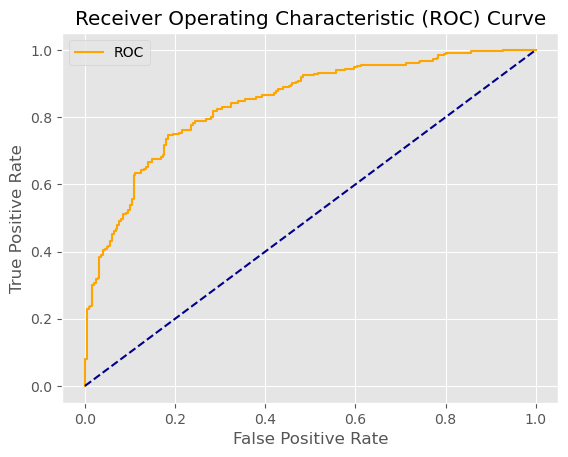

In [ ]:
# to plot ROC curve 
plt.style.use('ggplot') # to set plotting style

def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

plot_roc_curve(fpr,tpr)